In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction
Optimal Transport(OT) was first study by Gaspard Monge in 1781 who want to minimize her total effort to move a large pile of sand lying on a construction site. Mathematiciana interested in OT cast that problem as that of comparing two probability distributions.  
We say $a$ is an **histogram** or **probability vector** if it belongs to the **probability** simplex
$$
\Sigma_n = \left\{a \in \mathbb{R}^n_{+}: \sum_{i=1}^na_i=1\right\}
$$

## Kantorovich Problem
Given to histogram $a\in \Sigma_n$ and $b\in \Sigma_m$, $P\in \mathbb{R}^{n\times m}_{+}$ is the **coupling** matrix , where $P_{ij}$ describe the amount of mass flowing from bin $i$ to bin $j$. Admissible coupling admit a simple characterization that
$$
U(a, b) = \left\{P \in \mathbb{R}^{n\times m}_{+}: \sum_jP_{ij} = a_i, \sum_iP_{ij} = b_j\right\}
$$
The set of $U(a, b)$ defined by $m+n$ equality constraints.
Given a cost marix $C$, Kantorovich problem try to seek coupling matrix that minimize total effort
$$
L_C(a, b) = \min_{P\in U(a, b)}\left<P, C\right>
$$
This is a linear program and as is usually the case with such programs, its optimal solutions are not necessarily unique.
## Wasserstein Distance
An import feature of OT is that it defines a distacne between histograms as soon as the cost matrix $C = D^p$ where $D$ is a distance matrix. Then we can define so-called wasserstein distance on probability simplex $\Sigma_n$
$$
W_p(a, b) = L_{D^p}(a, b)^{1/p}
$$
## Entropic Regularization
We will introduce a family of numerical schemes to approximate solutions to Kantorovich formulation of OT. It operates by adding an entropic regularization to the original problem. The minimization of the regularized problem can be solved by using a simple alternate minimization scheme which are iterations of simple matrix-vector products. The resulting approximate distance is smooth with respect to input histogram weights and can be differentiated using automatic differentiation.  
The discrete entropy of the coupling matrix is defined as:
$$
H(P) = -\sum_{i, j}P_{ij}(\log(P_{ij})-1)
$$
The idea of the entropic regularization of OT is to use $-H$ as a regularization function to obtain approximate solutions to the origin Kantorovich OT problem:
$$
L^{\epsilon}_C(a, b) = \min_{P\in U(a, b)}\left<P, C\right> - \epsilon H(P)
$$
## Sinkhorn Algorithm
Let $K$ denote the Gibbs kernel associated to the cost matrix $C$ as:
$$
K_{ij} = e^{-\frac{C_{ij}}{\epsilon}}
$$
The solution of the regularized OT problem has the form:
$$
P_{ij} = u_iK_{ij}v_j
$$
for two (unknow) scaling variable $(u, v) \in \mathbb{R}^n_+\times\mathbb{R}^m_+$.
Then the problem will be reduced to matrix scaling problem which can be solved by Sinkhorn Algorithm
$$
u^{(l+1)} = \frac{a}{K\textbf{v}^(l)}, \quad v^{(l+1)} = \frac{b}{u^{(l+1)}}
$$
In order to speed up the Sinkhorn's iterations, we can compute several regularized Wasserstein distances between pairs of histograms simultaneously. Let $N$ be an integer, $a_1, \cdots,a_N$ be histograms in $\Sigma_n$, and $b_1, \cdots, b_N$ be histograms in $\Sigma_m$. We seek to compute all $N$ approximate distances $L_C^{\epsilon}(a_1, b_1), \cdots, L_C^{\epsilon}(a_N, b_N).$  In that case, writing $A = [a_1, \cdots, a_N]$ and $B = [b_1, \cdots,b_N]$ for the $n\times N$ and $m\times N$ matrices storing all histograms,  one can notice that all Sinkhorn iterations for all these $N$ pairs can be carried out in parallel, by setting, for instance, 
$$
U^{(l+1)} = \frac{A}{KV^(l)}, \quad V^{(l+1)} = \frac{B}{K^TU^{(l+1)}}
$$
initialized with $V^{(0)} = \mathbb{1}_{m\times N}.$

In [2]:
def cost_matrix(X, Y, p):
    """Computing the cost matrix, i.e.
        C_ij = ||x_i-y_j||_p^p
    """
    X_col = X[:, np.newaxis]
    Y_lin = Y[np.newaxis, :]
    C = np.sum((np.abs(X_col - Y_lin)) ** p, axis=2)
    return C

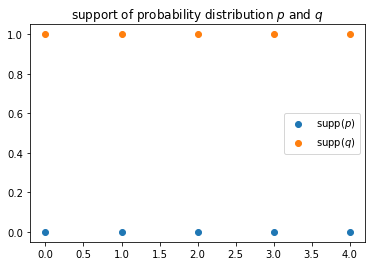

In [3]:
# Define two probability distribution 
n_points = 5
x = np.array([[i, 0] for i in range(n_points)])# support of p
y = np.array([[i, 1] for i in range(n_points)])# support of q
plt.scatter(x[:, 0], x[:, 1], label='supp($p$)')
plt.scatter(y[:, 0], y[:, 1], label='supp($q$)')
plt.title('support of probability distribution $p$ and $q$')
plt.legend()

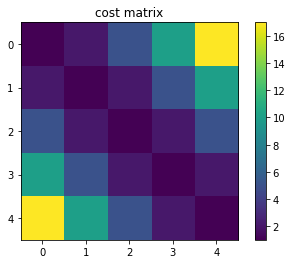

In [4]:
# Cost matrix
C = cost_matrix(x, y, 2)
plt.imshow(C)
plt.title('cost matrix')
plt.colorbar()

In [20]:
# Probability vector
a = np.ones((n_points)) / n_points
b = np.ones((n_points)) / n_points

In [23]:
def sinkhorn_iteration(a, b, C, eps, L):
    """Sinkhorn algotirhm
    """
    # Gibbs kernel
    K = np.exp(-C/eps)
    assert not np.any(np.isnan(K))
    v = np.ones((len(b), 1))
    for l in range(L):
        u = a[:, np.newaxis] / (K @ v)
        v = b[:, np.newaxis] / (K.T @ u)
    P = np.diag(u.squeeze()) @ K @ np.diag(v.squeeze())
    cost = np.sum(P * C)
    return P, cost

Sinkhorn distance of two distribution is 1.00007


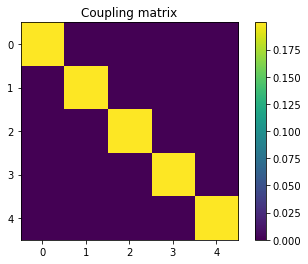

In [25]:
# Adjust epsilon to find how it influence the result
P, cost = sinkhorn_iteration(a, b, C, eps=0.1, L=100) 
print(f"Sinkhorn distance of two distribution is {cost:g}")
plt.figure()
plt.imshow(P)
plt.title('Coupling matrix')
plt.colorbar()
plt.show()

## Log-Domain Computations
When you set `eps` above to 0.01, you will find that the algorithm suffers from numerical overflow. This concern can be alleviated to some extent by carrying out computations in the log domain. The relevance of this approch is made more clear by the dual problem
$$
L^{\epsilon}_C(a, b) = \max_{f, g}\left<f, a\right> + \left<g, b\right> - \epsilon \left<e^{f/\epsilon}, Ke^{g/\epsilon}\right>
$$
The optimal $(f, g)$ are linked to scaling $(u, v)$ through
$$
(u, v) = (e^{f/\epsilon}, e^{g/\epsilon})
$$